In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

### Calendar

In [2]:
seattle_calendar = pd.read_csv("seattle/calendar.csv", parse_dates=['date'])
seattle_calendar['price'] = seattle_calendar['price'].str.replace(',', '')
seattle_calendar['price'] = seattle_calendar['price'].str.replace('$', '')
seattle_calendar['price'] = seattle_calendar['price'].astype(float)
seattle_calendar = seattle_calendar.set_index('date')

boston_calendar = pd.read_csv("boston/calendar.csv", parse_dates=['date'])
boston_calendar['price'] = boston_calendar['price'].str.replace(',', '')
boston_calendar['price'] = boston_calendar['price'].str.replace('$', '')
boston_calendar['price'] = boston_calendar['price'].astype(float)
boston_calendar = boston_calendar.set_index('date')

In [3]:
seattle_calendar.listing_id.nunique(), boston_calendar.listing_id.nunique()

(3818, 3585)

### Listings

In [4]:
seattle_listings = pd.read_csv("seattle/listings.csv")
seattle_listings['price'] = seattle_listings['price'].str.replace(',', '')
seattle_listings['price'] = seattle_listings['price'].str.replace('$', '')
seattle_listings['price'] = seattle_listings['price'].astype(float)

boston_listings = pd.read_csv("boston/listings.csv")
boston_listings['price'] = boston_listings['price'].str.replace(',', '')
boston_listings['price'] = boston_listings['price'].str.replace('$', '')
boston_listings['price'] = boston_listings['price'].astype(float)

### Reviews

In [5]:
seattle_reviews = pd.read_csv("seattle/reviews.csv")
boston_reviews = pd.read_csv("boston/reviews.csv")

In [6]:
seattle_reviews[(seattle_reviews.listing_id == 241032) & (seattle_reviews.comments.str.contains("bad"))].comments.iloc[0]

"The good:  Good location, comfortable space, comfortable bed, washer and dryer\r\nThe bad:  It smelled musty (it's an exposed basement), street noise is loud, there were many cobwebs, the only bar soap was soap used by previous tenants (I did bring our own just in case), very few towels, found bathroom floor mats in laundry room which seemed clean, found coffee maker in laundry room (after we bought one)."

# Questions

You can compare rates between the two cities, or try to understand if there is anything about the properties that helps you predict price. Can you find negative and positive reviews based on text? 

**Can we predict price? using location? reviews?<br>**
**</br>Can we classify text?<br>**
**How do these findings differ between boston and seattle</br>**

In [7]:
seattle_calendar.price.isna().mean(), boston_calendar.price.isna().mean()

(0.32938998399793334, 0.5087157820748879)

In [8]:
seattle_listings['beds'].isna().mean(), seattle_listings.bedrooms.isna().mean(), seattle_listings.price.isna().mean(),\
seattle_listings.zipcode.isna().mean()

(0.00026191723415400735, 0.001571503404924044, 0.0, 0.0018334206390780514)

In [9]:
pd.concat([seattle_calendar.groupby('listing_id').price.min(),
           seattle_calendar.groupby('listing_id').price.max()],axis=1)

,price,price
listing_id,,
3335,120.0,120.0
4291,82.0,82.0
5682,42.0,60.0
6606,90.0,100.0
7369,85.0,85.0
...,...,...
10332096,40.0,40.0
10334184,120.0,120.0
10339144,NaN,NaN


1) date
2) number of beds or bedrooms
3) property type
4) zipcode

# Graphing factors

In [10]:
seattle_listings.zipcode = seattle_listings.zipcode.replace("99\n98122", "98122")

seattle_listings = seattle_listings.dropna(subset=['zipcode']).astype({'zipcode': 'int64'})

## date

In [11]:
df = seattle_calendar.reset_index().merge(seattle_listings[['id', 'bedrooms', 'beds', 'property_type', 'zipcode']], 
                            left_on=['listing_id'], right_on=['id'], how='left')
df = df.set_index('date')

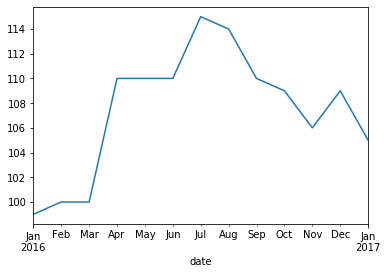

In [12]:
df.groupby(pd.Grouper(freq='M')).price.median().plot(label='seattle');

## number of bedrooms

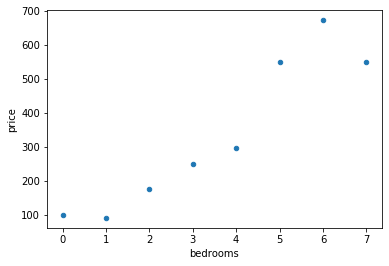

In [18]:
df.groupby('bedrooms').price.median().sort_index().to_frame().reset_index().plot(x='bedrooms',
                                                                                 y='price', kind='scatter');

## property type

In [24]:
seattle_listings.property_type.nunique()

16

In [27]:
# pd.concat([df.drop('property_type', axis=1),
#           pd.get_dummies(df.property_type, prefix='dummy')],axis=1)

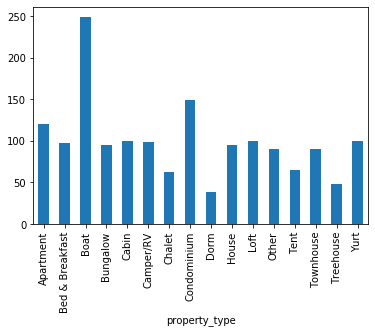

In [30]:
df.groupby('property_type').price.median().plot(kind='bar');

## zipcode

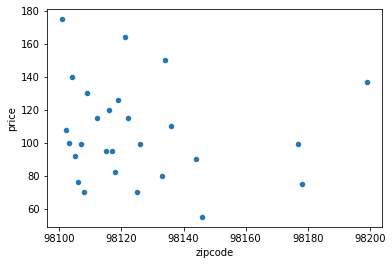

In [13]:
df.groupby('zipcode').price.median().sort_index().to_frame().reset_index().plot(x='zipcode',
                                                                                y='price', kind='scatter');

# LM

In [42]:
import datetime

In [48]:
df_ = df.reset_index().dropna(subset=['price', 'date', 'bedrooms', 'zipcode'])
df_['date'] = pd.to_datetime(df_['date'])
df_['date']= df_['date'].map(datetime.datetime.toordinal)

X = df_[['date', 'bedrooms', 'zipcode']]
y = df_[['price']]

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_test_preds = lm_model.predict(X_test) 
print(f"The r-squared score for the model using only quantitative variables was {r2_score(y_test, y_test_preds)} on {len(y_test)} values")

The r-squared score for the model using only quantitative variables was 0.4022280203828027 on 279387 values


In [76]:
df_ = df.reset_index().copy()
df_ = pd.concat([df_.drop('property_type', axis=1),
          pd.get_dummies(df_.property_type, prefix='dummy')],axis=1)

df_['date'] = pd.to_datetime(df_['date'])
df_['date']= df_['date'].map(datetime.datetime.toordinal)

df_ = df_.dropna()

X = df_.drop(['listing_id', 'available', 'price', 'id', 'zipcode'], axis=1)
y = df_[['price']]

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_train_preds = lm_model.predict(X_train)
y_test_preds = lm_model.predict(X_test)

train_score = r2_score(y_train, y_train_preds)
test_score = r2_score(y_test, y_test_preds)

print(f"Train R squared: {round(train_score, 3)}, Test R squared: {round(test_score,3)}")


Train R squared: 0.478, Test R squared: 0.481


# Finally using zipcode

In [77]:
df_ = df.reset_index().copy()
df_ = pd.concat([df_.drop('zipcode', axis=1),
          pd.get_dummies(df_.zipcode, prefix='dummy')],axis=1)

df_['date'] = pd.to_datetime(df_['date'])
df_['date']= df_['date'].map(datetime.datetime.toordinal)

df_ = df_.dropna()

X = df_.drop(['listing_id', 'available', 'price', 'id', 'property_type'], axis=1)
y = df_[['price']]

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_train_preds = lm_model.predict(X_train)
y_test_preds = lm_model.predict(X_test)

train_score = r2_score(y_train, y_train_preds)
test_score = r2_score(y_test, y_test_preds)

print(f"Train R squared: {round(train_score, 3)}, Test R squared: {round(test_score,3)}")


Train R squared: 0.519, Test R squared: 0.523


# Combining everything

In [79]:
df_ = df.reset_index().copy()
df_ = pd.concat([df_.drop('zipcode', axis=1),
          pd.get_dummies(df_.zipcode, prefix='dummy')],axis=1)
df_ = pd.concat([df_.drop('property_type', axis=1),
          pd.get_dummies(df_.property_type, prefix='dummy')],axis=1)

df_['date'] = pd.to_datetime(df_['date'])
df_['date']= df_['date'].map(datetime.datetime.toordinal)

df_ = df_.dropna()

X = df_.drop(['listing_id', 'available', 'price', 'id'], axis=1)
y = df_[['price']]

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_train_preds = lm_model.predict(X_train)
y_test_preds = lm_model.predict(X_test)

train_score = r2_score(y_train, y_train_preds)
test_score = r2_score(y_test, y_test_preds)

print(f"Train R squared: {round(train_score, 3)}, Test R squared: {round(test_score,3)}")


Train R squared: 0.531, Test R squared: 0.534


# How does Boston do in comparison?

In [80]:
df = boston_calendar.reset_index().merge(boston_listings[['id', 'bedrooms', 'beds', 'property_type', 'zipcode']], 
                            left_on=['listing_id'], right_on=['id'], how='left')
df = df.set_index('date')

In [82]:
df_ = df.reset_index().copy()
df_ = pd.concat([df_.drop('zipcode', axis=1),
          pd.get_dummies(df_.zipcode, prefix='dummy')],axis=1)
df_ = pd.concat([df_.drop('property_type', axis=1),
          pd.get_dummies(df_.property_type, prefix='dummy')],axis=1)

df_['date'] = pd.to_datetime(df_['date'])
df_['date']= df_['date'].map(datetime.datetime.toordinal)

df_ = df_.dropna()

X = df_.drop(['listing_id', 'available', 'price', 'id', 'date'], axis=1)
y = df_[['price']]

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_train_preds = lm_model.predict(X_train)
y_test_preds = lm_model.predict(X_test)

train_score = r2_score(y_train, y_train_preds)
test_score = r2_score(y_test, y_test_preds)

print(f"Train R squared: {round(train_score, 3)}, Test R squared: {round(test_score,3)}")


Train R squared: 0.379, Test R squared: 0.368


# Fake reviews

In [135]:
seattle_reviews.reviewer_id.value_counts()

206203      67
15121499    32
5775807     19
2734499     19
29590276    18
            ..
31487463     1
13532646     1
9373300      1
28722657     1
22282240     1
Name: reviewer_id, Length: 75730, dtype: int64

In [151]:
df = seattle_reviews[seattle_reviews.reviewer_id == 206203].copy()
df.date = pd.to_datetime(df.date)
df = df.set_index('date')

In [152]:
df.groupby(df.index.year).count()

,listing_id,id,reviewer_id,reviewer_name,comments
date,,,,,
2013,9,9,9,9,9
2014,4,4,4,4,4
2015,6,6,6,6,6


In [146]:
df.iloc[7,4]

'Susanna is an outstanding host! Her home is absolutely lovely in the perfect location! Every detail was attended to and I could not have felt more welcome. Highly recommend!!'

In [166]:
df = seattle_listings[['id', 'review_scores_value']]

In [169]:
df = seattle_reviews.merge(df, left_on='listing_id', right_on='id', how='left')

In [175]:
amanda = df[df.reviewer_id == 206203]

In [179]:
amanda.review_scores_value.value_counts() / amanda.shape[0]

10.0    0.656716
9.0     0.298507
8.0     0.044776
Name: review_scores_value, dtype: float64